## Imports

### Libraries

In [139]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim
import wandb

### Tensorboard

In [140]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [141]:
writer = SummaryWriter()

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


### Custom

In [142]:
from cv_geoguessr.data.StreetViewImagesDataset import StreetViewImagesDataset

from cv_geoguessr.grid.grid_partitioning import Partitioning

from cv_geoguessr.utils.plot_images import plot_images

## Colab specific

Run only when using Colab.

In [ ]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

## Logging in via WandB

In [ ]:
wandb.init(project="CV-GeoGuessr", entity="cv-geoguessr", sync_tensorboard=True)

## Model constants

In [143]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 100
CELL_WIDTH = 0.04

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device = device)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device = device)

CITY_BOUNDS_FILE = '../data/metadata/citybounds/london.csv'
GCLOUD_CITY_BOUNDS_FILE = '../data/metadata/city bounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
SJOERD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train_img" if train else "test_img"}/'
GCLOUD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train" if train else "test"}/'

LONDON_PHOTO_DIR = LOCAL_LONDON_PHOTO_DIR

SESSION = "douwes_v1_test"
CHECKPOINT_FOLDER = f'../checkpoints/{SESSION}/'


In [ ]:
wandb.config.update({"train_batch_size": TRAIN_BATCH_SIZE, "test_batch_size": TEST_BATCH_SIZE, "cell_width": CELL_WIDTH})

### ImageNet setup

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

In [144]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

### Places365 setup

In [ ]:
# load the class label
file_name = 'categories_places365.txt'

if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)

categories = list()

with open(file_name) as class_file:
    for line in class_file:
        categories.append(line.strip().split(' ')[0][3:])
        
classes = tuple(categories)

## Download ResNet50

### Original

In [145]:
resnet50 = models.resnet50(pretrained=True, progress=True)

resnet50.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Places365

In [ ]:
# th architecture to use
arch = 'resnet50'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

resnet50 = model

resnet50.to(device)

### Show summary

In [146]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Load the data

### Create the data loaders

In [148]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    # How about ipv centercrop, wat bij streetview foto's mschn biased kan zijn, een random crop of fivecrop. Dit zorgde voor errors maar kan later bekeken worden
    # transforms.CenterCrop((224, 224)),
    # transforms.RandomCrop(size = (224,224)),
    # transforms.ColorJitter(brightness = 0.2, contrast = 0, saturation = 0.05, hue = 0.1),
    # transforms.RandomPerspective(distortion_scale = .4, p = .4),
])

grid_partitioning = Partitioning(CITY_BOUNDS_FILE, CELL_WIDTH)

train_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(True), grid_partitioning, data_transforms)
train_loader = DataLoader(train_data_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(False), grid_partitioning, data_transforms)
test_loader = DataLoader(test_data_set, batch_size=TEST_BATCH_SIZE, shuffle=True)


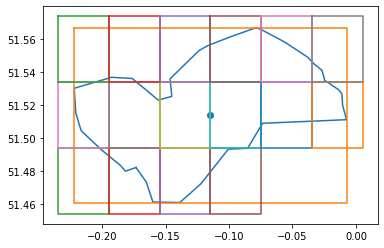

In [149]:
grid_partitioning.plot()

### Preview some images

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


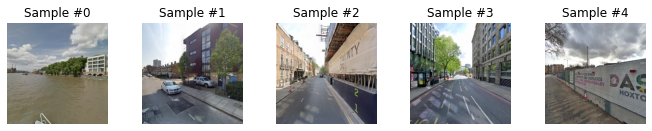

In [150]:
examples = enumerate(test_loader)
batch_idx, (eval_images, eval_coordinates) = next(examples)
eval_images = eval_images.to(device)
eval_coordinates = eval_coordinates.to(device)

plot_images(eval_images[:SAMPLES_TO_SHOW].cpu(), IMAGENET_MEAN.cpu(), IMAGENET_STD.cpu())

### Preview some output vectors

In [151]:
for i in range(SAMPLES_TO_SHOW):
    print(eval_coordinates[i, :])

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


## Evaluate the model
...with the current/original backbone

In [ ]:
resnet50.eval()

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(eval_images[:SAMPLES_TO_SHOW]), dim=1)

In [ ]:
for i in output:
    top5_prob, top5_catid = torch.topk(i, 5)

    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print("")

##  Change network backbone to grid cells

In [152]:
lr = 0.001
momentum = 0.9
gamma = 0.1
lr_decay_step = 7
num_epochs = 50

wandb.config.update({"lr": lr, "momentum": momentum, "gamma": gamma, "lr_decay_step": lr_decay_step, "epochs": num_epochs})

In [153]:
from torch.optim import lr_scheduler
from torch import optim

number_of_grid_elements = len(grid_partitioning.cells)

for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc = nn.Linear(resnet50.fc.in_features, number_of_grid_elements).to(device)
resnet50.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(resnet50.fc.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=lr_decay_step, gamma=gamma)

In [ ]:
wandb.config.update({"number_of_grid_elements": number_of_grid_elements})

In [154]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Set up training pipeline

In [155]:
import copy
from datetime import time

data_loaders = {
    "train": train_loader,
    "val": test_loader
}


data_set_sizes = {
    'train': len(train_data_set),
    'val': len(test_data_set),
}

print(data_set_sizes)

{'train': 10038, 'val': 2000}


In [156]:
import os

if not os.path.isdir(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)

torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "untrained.ckpt")

In [163]:
import copy
import time


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Trains a model, based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

    :param model: the model to train
    :param criterion: the criterion to use
    :param optimizer: the optimizer to use
    :param scheduler: torch.optim.lr_scheduler
    :param num_epochs:
    :return: a trained model
    """

    since = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    distance_error_per_epoch = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_acc = 0
        test_acc = 0

        distance_error = {}
        distance_error_count = {}

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward: track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # Add distance error metric
                    _, actual_label_index = torch.max(labels, 1)
                    for index, label in enumerate(actual_label_index[preds != actual_label_index].tolist()):
                        distance_error.setdefault(label, 0)
                        distance_error[label] += (grid_partitioning.cells[label].centroid).distance(grid_partitioning.cells[preds[index]].centroid)

                        distance_error_count.setdefault(label, 0)
                        distance_error_count[label] += 1

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                _, actual_label_index = torch.max(labels, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == actual_label_index)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / data_set_sizes[phase]
            epoch_acc = running_corrects.double() / data_set_sizes[phase]

            # writer.add_scalar(f"Loss/{phase}", epoch_loss, epoch)
            wandb.log({f"Loss/{phase}": epoch_loss, "epoch": epoch})
            # writer.add_scalar(f"Accuracy/{phase}", epoch_acc, epoch)
            wandb.log({f"Accuracy/{phase}": epoch_acc, "epoch": epoch})

            if phase == 'train':
                train_acc = epoch_acc
            else:
                test_acc = epoch_acc

            print(f'{phase} loss: {epoch_loss:.4f} | accuracy: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())


        # Append avg distance error
        for k in distance_error:
            distance_error[k] /= distance_error_count[k]
        distance_error_per_epoch.append(distance_error)

        print(f"{train_acc}\t{test_acc}")

        torch.save(resnet50.state_dict(),
                   CHECKPOINT_FOLDER + f"epoch_{epoch}.ckpt")

    time_elapsed = time.time() - since

    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model)

    # writer.flush()

    return model


## Set up Tensorboard

In [ ]:
%tensorboard --logdir runs/

In [ ]:
# Lets train the model
trained_model = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)


## Clean up TensorBoard data

In [ ]:
!rm -r runs

## Load trained model

In [159]:
trained_resnet50 = resnet50

trained_resnet50.load_state_dict(torch.load("../checkpoints/epoch_24.ckpt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [165]:
train_model(trained_resnet50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/49
----------
{14: 0.08459007991403293, 11: 0.05656854249492823, 8: 0.06992038844285542, 13: 0.06812559200041543, 6: 0.026666666666666523, 5: 0.06264281004514323, 2: 0.0876067569569484, 3: 0.056568542494923185, 9: 0.0882842712474641, 7: 0.03999999999999999, 1: 0.10523896302656467, 4: 0.09463213313049504, 12: 0.06314337781594208}
{14: 0.036628457637741585, 11: 0.05656854249492823, 8: 0.048455414495605226, 13: 0.04709360900890266, 6: 0.029607824258132194, 5: 0.03165938148658585, 2: 0.043517757675774864, 3: 0.09152982445082902, 9: 0.022071067811866026, 7: 0.020000000000000517, 1: 0.05584146631827383, 4: 0.03889990772551924, 12: 0.02853027433012432, 15: 0.08}
{14: 0.02662760928830549, 11: 0.07300563079746131, 8: 0.026883855288361916, 13: 0.03766579212375313, 6: 0.011924015281377445, 5: 0.024443982918021072, 2: 0.013328082739848864, 3: 0.04384327481694272, 9: 0.06750532806253313, 7: 0.006250000000000032, 1: 0.03946899180989139, 4: 0.04769731919282582, 12: 0.021454153592504892, 15: 0

KeyboardInterrupt: 

wandb: Network error (ConnectionError), entering retry loop.
